<a target="_blank" rel="noopener noreferrer" href="https://colab.research.google.com/github/ccaudek/ds4psy_2023/blob/main/05_reglin_5.ipynb">![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)</a>

(multilevel-notebook)=
# Il modello lineare gerarchico

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import arviz as az
import bambi as bmb
import pymc.sampling_jax
import xarray as xr
import pingouin as pg

/Users/corrado/mambaforge/envs/pymc_env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
%config InlineBackend.figure_format = 'retina'

RANDOM_SEED = 42
rng = np.random.default_rng(RANDOM_SEED)

from aquarel import load_theme
theme = load_theme("minimal_light")
theme.apply()
import matplotlib.style as style 
style.use("tableau-colorblind10")

In questo capitolo, approfondiremo la metodologia della regressione lineare gerarchica Bayesiana, utilizzando le API della libreria Bambi. L'obiettivo è di applicare questo  metodo statistico a un dataset multilivello. In particolare, ci concentreremo su un dataset che comprende diverse unità di osservazione (i soggetti), ognuna delle quali ha più misurazioni associate. 

Abbiamo già introdotto il concetto di modellazione gerarchica Bayesiana, focalizzandoci in precedenza sulla stima dei parametri di una distribuzione di probabilità (per ulteriori dettagli, si rimanda al capitolo {ref}`hier_beta_binom_model`). In questo capitolo, estenderemo quel concetto alla stima dei parametri di un modello di regressione lineare, dove i dati sono raggruppati in diversi cluster.

Esamineremo e metteremo a confronto tre tipi di modelli gerarchici.

1. **Complete Pooling**: Questo modello ignora completamente la struttura gerarchica dei dati. In altre parole, tratta tutte le unità di osservazione come se fossero provenienti da un'unica popolazione.
2. **No Pooling**: Questo modello, al contrario, considera ogni cluster come completamente indipendente dagli altri, senza alcuna struttura gerarchica.
3. **Partial Pooling** (o Modello Multi-Livello): Questo modello è il più sofisticato tra i tre. Assume che le pendenze e le intercette di ciascun cluster siano realizzazioni di variabili casuali, estratte da una distribuzione normale con media e varianza comuni a tutti i cluster.

Il modello di "partial pooling" si distingue per la sua capacità di riconoscere la natura intrinsecamente gerarchica dei dati. Fornisce un equilibrio tra il "no pooling", che tratta ogni cluster come indipendente, e il "complete pooling", che normalizza eccessivamente i dati. In questo modello, le stime dei parametri per ciascun cluster sono influenzate sia dai dati specifici del cluster stesso sia dalla distribuzione globale dei dati tra tutti i cluster. Questo permette un "shrinkage" dei parametri, mitigando l'effetto di outliers o di cluster di dimensioni ridotte.

Per illustrare l'applicazione pratica di questi concetti, utilizzeremo il dataset `sleepstudy`. Questo dataset proviene dalla ricerca di Belenky et al. (2003) e contiene i tempi di reazione medi giornalieri (misurati in millisecondi) di un gruppo di partecipanti sottoposti a deprivazione del sonno. Il design dello studio prevede una fase iniziale di calibrazione e adattamento nei primi due giorni, seguita da una misurazione di baseline al terzo giorno. Dopo questo periodo, inizia la fase di deprivazione del sonno, durante la quale i partecipanti sono limitati a un regime di solo 3 ore di sonno per notte.

## EDA

Iniziamo importando i dati e ispezionando la struttura delle osservazioni suddivise nei diversi cluster. 

In [8]:
data = bmb.load_data("sleepstudy")
data.head()

Reaction  Days  Subject
0  249.5600     0      308
1  258.7047     1      308
2  250.8006     2      308
3  321.4398     3      308
4  356.8519     4      308

Eliminiamo le righe in cui la colonna "Days" ha valore 0 o 1 dal dataset "sleepstudy" utilizzando il seguente codice:

In [9]:
data = data[data['Days'].isin([0, 1]) == False]
data.head()

Reaction  Days  Subject
2  250.8006     2      308
3  321.4398     3      308
4  356.8519     4      308
5  414.6901     5      308
6  382.2038     6      308

Analizziamo il tempo di reazione medio in relazione ai giorni di deprivazione del sonno, osservando come questo varia per ciascun soggetto coinvolto nello studio.

In [10]:
def plot_data(data):
    fig, axes = plt.subplots(2, 9, figsize=(24, 7.5), sharey=True, sharex=True, dpi=300, constrained_layout=True)
    fig.subplots_adjust(left=0.075, right=0.975, bottom=0.075, top=0.925, wspace=0.03)

    axes_flat = axes.ravel()

    for i, subject in enumerate(data["Subject"].unique()):
        ax = axes_flat[i]
        idx = data.index[data["Subject"] == subject].tolist()
        days = data.loc[idx, "Days"].values
        reaction = data.loc[idx, "Reaction"].values

        # Plot observed data points
        ax.scatter(days, reaction, color="C0", ec="black", alpha=0.7)

        # Add a title
        ax.set_title(f"Subject: {subject}", fontsize=14)

    # Remove axis labels for individual plots
    for ax in axes_flat:
        ax.set_xlabel('')
        ax.set_ylabel('')

    # Set x-axis ticks for the last row
    for ax in axes[-1]:
        ax.xaxis.set_ticks([0, 2, 4, 6, 8])

    return axes

In [11]:
plot_data(data)
plt.tight_layout();

/var/folders/hl/dt523djx7_q7xjrthzjpdvc40000gn/T/ipykernel_73780/2047360606.py:3: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  fig.subplots_adjust(left=0.075, right=0.975, bottom=0.075, top=0.925, wspace=0.03)
/var/folders/hl/dt523djx7_q7xjrthzjpdvc40000gn/T/ipykernel_73780/3301838130.py:2: UserWarning: The figure layout has changed to tight
  plt.tight_layout();


## Modello complete pooling

Il modello complete pooling tratta tutte le osservazioni come se fossero indipendenti, aggregandole in un unico gruppo. In questo modello, le rette di regressione lineare per tutti i soggetti hanno la stessa pendenza e la stessa intercetta. Il modello può essere descritto esplicitamente come segue:

Se disponiamo di $ m $ soggetti e ciascun soggetto $ i $ ha $ n_i $ osservazioni, il modello può essere definito da:

$$
\begin{align*}
\text{Per il soggetto } i = 1, \ldots, m, \text{ e per l'osservazione } j = 1, \ldots, n_i:
\end{align*}
$$

$$
\begin{align*}
\text{Reaction}_{ij} &= \alpha + \beta \cdot \text{Days}_{ij} + \epsilon_{ij}, \\
\epsilon_{ij} &\sim \mathcal{N}(0, \sigma^2),
\end{align*}
$$

dove:

- $\text{Reaction}_{ij}$ è il tempo di reazione per il soggetto $ i $ al giorno $ j $.
- $\text{Days}_{ij}$ è il numero di giorni per il soggetto $ i $ all'osservazione $ j $.
- $\alpha$ è l'intercetta comune a tutti i soggetti.
- $\beta$ è la pendenza comune a tutti i soggetti.
- $\epsilon_{ij}$ è il termine di errore casuale per il soggetto $ i $ all'osservazione $ j $, che si suppone sia distribuito normalmente con media 0 e varianza costante $ \sigma^2 $.

Questo modello non distingue tra i gruppi di osservazoni che appartengono a soggetti diversi e stima un'unica pendenza e un'unica intercetta dai dati di tutti i soggetti. In Bambi, questo modello può essere specificato utilizzando solo la variabile `Days` come predittore, senza includere il `Subject` come fattore.

In [12]:
model_pooling = bmb.Model("Reaction ~ 1 + Days", data)

Procediamo con l'esecuzione del campionamento MCMC, utilizzando il metodo NUTS specifico per il campionatore JAX. Questo può essere fatto semplicemente passando l'opzione `method="nuts_numpyro"` durante la chiamata al campionamento. In questo modo, stiamo invocando direttamente il campionatore JAX, sfruttando le sue caratteristiche avanzate.

In [13]:
results_pooling = model_pooling.fit(
    method="nuts_numpyro", idata_kwargs={"log_likelihood": True}
)

/Users/corrado/mambaforge/envs/pymc_env/lib/python3.11/site-packages/bambi/models.py:307: FutureWarning: the method argument has been deprecated, please use inference_method
  warnings.warn(


Compiling...
Compilation time =  0:00:04.886626
Sampling...


Compiling.. :   0%|          | 0/2000 [00:00<?, ?it/s]







Running chain 3: 100%|██████████| 2000/2000 [00:03<00:00, 591.13it/s]


Sampling time =  0:00:03.824537
Transforming variables...
Transformation time =  0:00:00.028387
Computing Log Likelihood...
Log Likelihood time =  0:00:00.401715


Un sommario numerico delle distribuzioni a posteriori dei parametri si ottiene con `az.summary`.

In [14]:
az.summary(results_pooling, round_to=2)

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
Intercept       245.60  11.23  225.06   266.75       0.18     0.13   3891.74   
Days             11.35   1.90    7.51    14.58       0.03     0.02   3648.84   
Reaction_sigma   51.15   3.10   45.25    56.78       0.05     0.03   4029.40   

                ess_tail  r_hat  
Intercept        2773.69    1.0  
Days             2858.85    1.0  
Reaction_sigma   2810.01    1.0

## Modello no-pooling

Il modello no-pooling tratta ogni soggetto come indipendente e adatta una retta di regressione  separata per ciascun soggetto. Se disponiamo di $ m $ soggetti e ciascun soggetto $ i $ ha $ n_i $ osservazioni, il modello può essere definito da:

$$
\begin{align*}
\text{Per il soggetto } i = 1, \ldots, m:
\end{align*}
$$

$$
\begin{align*}
\text{Reaction}_{ij} &= \alpha_i + \beta_i \cdot \text{Days}_{ij} + \epsilon_{ij}, \\
\epsilon_{ij} &\sim \mathcal{N}(0, \sigma^2), \quad j = 1, \ldots, n_i,
\end{align*}
$$

dove:

- $\text{Reaction}_{ij}$ è il tempo di reazione per il soggetto $ i $ al giorno $ j $.
- $\text{Days}_{ij}$ è il numero di giorni per il soggetto $ i $ all'osservazione $ j $.
- $\alpha_i$ è l'intercetta per il soggetto $ i $.
- $\beta_i$ è la pendenza per il soggetto $ i $.
- $\epsilon_{ij}$ è il termine di errore casuale per il soggetto $ i $ all'osservazione $ j $, che si suppone sia distribuito normalmente con media 0 e varianza costante $ \sigma^2 $.

Questo modello non fa alcuna ipotesi sulle relazioni tra diversi soggetti e stima la pendenza e l'intercetta di ciascun soggetto indipendentemente dagli altri soggetti. In Bambi, questo modello viene specificato con l'interazione tra `Days` e `Subject`, come descritto in seguito.

In [15]:
model_no_pooling = bmb.Model("Reaction ~ Days * C(Subject)", data=data)
results_no_pooling = model_no_pooling.fit(
    method="nuts_numpyro", idata_kwargs={"log_likelihood": True}
)

/Users/corrado/mambaforge/envs/pymc_env/lib/python3.11/site-packages/formulae/terms/call.py:108: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_string_dtype(x) or is_categorical_dtype(x) or isinstance(x, CategoricalBox):
/Users/corrado/mambaforge/envs/pymc_env/lib/python3.11/site-packages/formulae/terms/call.py:108: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_string_dtype(x) or is_categorical_dtype(x) or isinstance(x, CategoricalBox):
/Users/corrado/mambaforge/envs/pymc_env/lib/python3.11/site-packages/bambi/models.py:307: FutureWarning: the method argument has been deprecated, please use inference_method
  warnings.warn(


Compiling...
Compilation time =  0:00:02.736966
Sampling...


Compiling.. :   0%|          | 0/2000 [00:00<?, ?it/s]






Running chain 0:   0%|          | 0/2000 [00:04<?, ?it/s]


Running chain 0:   5%|▌         | 100/2000 [00:04<00:05, 348.44it/s]


Running chain 0:  40%|████      | 800/2000 [00:05<00:00, 2525.23it/s]


Running chain 0:  80%|████████  | 1600/2000 [00:05<00:00, 4218.82it/s]

Running chain 3: 100%|██████████| 2000/2000 [00:05<00:00, 384.84it/s] 


Sampling time =  0:00:05.536878
Transforming variables...
Transformation time =  0:00:00.008185
Computing Log Likelihood...
Log Likelihood time =  0:00:00.193210


In [16]:
az.summary(results_no_pooling, round_to=2)

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
Intercept             247.05  22.12  205.45   287.93       1.19     0.84   
Days                   21.29   3.70   14.38    28.25       0.20     0.14   
C(Subject)[309]       -54.96  32.02 -116.23     4.21       1.24     0.88   
C(Subject)[310]       -29.03  32.77  -90.70    30.44       1.26     0.89   
C(Subject)[330]         9.89  32.19  -49.75    68.28       1.30     0.92   
C(Subject)[331]        41.29  32.25  -14.67   107.08       1.27     0.90   
C(Subject)[332]        63.20  32.81    0.16   120.42       1.34     0.95   
C(Subject)[333]        17.12  32.47  -47.67    74.22       1.31     0.93   
C(Subject)[334]       -45.14  32.30 -101.29    19.40       1.29     0.91   
C(Subject)[335]        23.95  32.63  -38.98    82.76       1.28     0.91   
C(Subject)[337]        20.40  32.45  -38.76    80.97       1.34     0.95   
C(Subject)[349]       -51.06  32.30 -112.49     8.90       1.30     0.92   
C(Subject)[350]       -45.54  32.66 -108.91    12.68       1.25     0.88   
C(Subject)[351]        -0.52  32.32  -60.89    59.95       1.33     0.94   
C(Subject)[352]        69.23  32.03   14.26   133.89       1.27     0.90   
C(Subject)[369]        -7.85  32.43  -71.10    49.84       1.28     0.90   
C(Subject)[370]       -53.66  32.27 -116.45     4.75       1.32     0.93   
C(Subject)[371]       -13.80  32.55  -74.30    47.99       1.30     0.92   
C(Subject)[372]        21.63  32.32  -40.28    79.96       1.31     0.93   
Days:C(Subject)[309]  -17.01   5.41  -27.17    -6.77       0.21     0.15   
Days:C(Subject)[310]  -17.35   5.55  -27.69    -7.33       0.22     0.16   
Days:C(Subject)[330]  -13.25   5.43  -23.11    -2.92       0.22     0.16   
Days:C(Subject)[331]  -16.34   5.37  -26.49    -6.41       0.21     0.15   
Days:C(Subject)[332]  -18.69   5.53  -29.08    -8.60       0.23     0.16   
Days:C(Subject)[333]  -10.49   5.47  -20.63    -0.01       0.22     0.16   
Days:C(Subject)[334]   -3.19   5.40  -13.66     6.37       0.22     0.15   
Days:C(Subject)[335]  -25.44   5.43  -35.76   -15.51       0.21     0.15   
Days:C(Subject)[337]    1.20   5.47   -8.96    11.60       0.22     0.16   
Days:C(Subject)[349]   -4.85   5.37  -14.41     5.54       0.21     0.15   
Days:C(Subject)[350]    1.99   5.49   -7.75    12.67       0.21     0.15   
Days:C(Subject)[351]  -12.74   5.39  -22.30    -2.15       0.22     0.15   
Days:C(Subject)[352]  -13.97   5.37  -24.36    -4.32       0.21     0.15   
Days:C(Subject)[369]   -7.49   5.48  -17.64     2.62       0.22     0.15   
Days:C(Subject)[370]   -0.59   5.44  -11.26     9.02       0.22     0.15   
Days:C(Subject)[371]   -8.95   5.44  -18.82     1.68       0.22     0.16   
Days:C(Subject)[372]  -10.24   5.42  -19.81     0.44       0.22     0.16   
Reaction_sigma         25.84   1.77   22.59    29.22       0.03     0.02   

                      ess_bulk  ess_tail  r_hat  
Intercept               345.87    767.11   1.01  
Days                    340.98    721.68   1.01  
C(Subject)[309]         662.96   1480.51   1.00  
C(Subject)[310]         675.07   1651.19   1.00  
C(Subject)[330]         609.29   1487.16   1.00  
C(Subject)[331]         643.49   1431.84   1.00  
C(Subject)[332]         601.71   1431.76   1.00  
C(Subject)[333]         615.42   1516.89   1.00  
C(Subject)[334]         629.97   1653.52   1.00  
C(Subject)[335]         647.77   1322.80   1.01  
C(Subject)[337]         587.43   1504.82   1.00  
C(Subject)[349]         612.36   1259.01   1.00  
C(Subject)[350]         681.90   1489.16   1.00  
C(Subject)[351]         593.76   1570.39   1.00  
C(Subject)[352]         639.14   1393.35   1.00  
C(Subject)[369]         642.45   1373.48   1.00  
C(Subject)[370]         596.71   1492.39   1.00  
C(Subject)[371]         623.71   1512.95   1.00  
C(Subject)[372]         606.53   1492.25   1.00  
Days:C(Subject)[309]    635.65   1598.80   1.00  
Days:C(Subject)[310]    641.99   1688.17   1.00  
Days:C(Subject)[330]    612.84   15

Per ricavare i coefficienti $\alpha$ delle regressioni individuali, dobbiamo sommare `Intercept` al valore del singolo soggetto. Per esempio, per il soggetto 309 abbiamo

In [17]:
246.98 + -55.29

191.69

Facciamo lo stesso per la pendenza individuale delle rette di regressione. Per il soggetto 309 otteniamo

In [18]:
21.30 + -16.97

4.330000000000002

Questi valori sono identici a quelli che si otterrebbero se adattassimo il modello di regressione separatamente per ciascun soggetto. In effetti, abbiamo fatto proprio questo, anche se utilizzando un modello unico. Per esempio, esaminiamo solo i dati del soggetto 309.

In [17]:
data_subject_309 = data[data["Subject"] == 309]
data_subject_309.shape

(8, 3)

Per questi dati, stimiamo l'intercetta e la pendenza della retta di regressione usando l'approccio frequentista mediante la funzione `linear_regression` del pacchetto `pingouin`.

In [18]:
result = pg.linear_regression(data_subject_309["Days"], data_subject_309["Reaction"])
print(result)

       names        coef        se          T          pval        r2  \
0  Intercept  191.576970  3.723259  51.454104  3.615788e-09  0.890144   
1       Days    4.357144  0.624898   6.972569  4.325982e-04  0.890144   

     adj_r2    CI[2.5%]   CI[97.5%]  
0  0.871834  182.466483  200.687457  
1  0.871834    2.828074    5.886214  


Si noti che i risultati ottenuti sono sostanzialmente gli stessi, con solo qualche minima differenza numerica. Questa discrepanza deriva dalla diversità degli approcci utilizzati: in un caso abbiamo applicato un metodo bayesiano, mentre nell'altro abbiamo adottato una tecnica di stima frequentista.

## Modello partial pooling

Il modello gerarchico, conosciuto anche come modello di "partial pooling", consente di gestire la complessità presente nei dati raggruppati o clusterizzati, come nel caso presente. La regressione lineare classica presume che ogni osservazione sia indipendente dalle altre, ma questa ipotesi viene meno quando i dati sono organizzati in gruppi. Le osservazioni all'interno dello stesso gruppo tendono ad essere più correlate tra loro rispetto a quelle in gruppi diversi. Trascurare questa struttura gerarchica potrebbe portare a stime errate e conclusioni fuorvianti.

Il modello gerarchico affronta questo problema introducendo la nozione di effetti casuali, in contrapposizione agli effetti fissi del modello classico. Gli effetti fissi rappresentano l'effetto medio di una variabile predittiva su tutti gli individui o gruppi, mentre gli effetti casuali considerano come l'effetto di una variabile possa variare da un gruppo all'altro. Mentre gli effetti fissi sono comuni a tutto il dataset, gli effetti casuali tengono conto delle differenze tra i gruppi.

Questo modello gerarchico unisce effetti fissi e casuali per fornire una rappresentazione più accurata dei dati, quando questi mostrano relazioni gerarchiche o raggruppate. Il modello gerarchico di "partial pooling" considera le somiglianze tra i soggetti stimando un'intercetta e una pendenza comuni, ma consente anche variazioni individuali attorno a questi valori medi.

Possiamo rappresentare matematicamente il modello come segue:

$$
\begin{align*}
\text{Per il soggetto } i = 1, \ldots, m, \text{ e per l'osservazione } j = 1, \ldots, n_i:
\end{align*}
$$

$$
\begin{align*}
\text{Reaction}_{ij} &= \alpha_i + \beta_i \cdot \text{Days}_{ij} + \epsilon_{ij}, \\
\epsilon_{ij} &\sim \mathcal{N}(0, \sigma^2),
\end{align*}
$$

dove:

- $\text{Reaction}_{ij}$ è il tempo di reazione del soggetto $i$ al giorno $j$.
- $\text{Days}_{ij}$ è il numero di giorni per il soggetto $i$ all'osservazione $j$.
- $\alpha_i$ è l'intercetta per il soggetto $i$, che segue la distribuzione $\alpha_i \sim \mathcal{N}(\alpha, \tau_\alpha^2)$.
- $\beta_i$ è la pendenza per il soggetto $i$, che segue la distribuzione $\beta_i \sim \mathcal{N}(\beta, \tau_\beta^2)$.
- $\epsilon_{ij}$ è l'errore casuale per il soggetto $i$ all'osservazione $j$, distribuito normalmente con media 0 e varianza costante $\sigma^2$.

I parametri $\alpha$ e $\beta$ rappresentano l'intercetta e la pendenza medie per tutti i soggetti, e le varianze $\tau_\alpha^2$ e $\tau_\beta^2$ quantificano le differenze tra gli individui.

In questo modo, il modello gerarchico riesce a rappresentare sia le informazioni comuni a tutti i soggetti, sia le differenze individuali, considerando sia gli effetti fissi che quelli casuali. Può quindi offrire una visione più completa e realistica dei dati, tenendo conto della loro struttura gerarchica. In Bambi, questo modello può essere specificato utilizzando la variabile `Days` come predittore e includendo `Subject` come effetto casuale.

In [19]:
model_partial_pooling = bmb.Model(
    "Reaction ~ 1 + Days + (Days | Subject)", data, categorical="Subject"
)

/Users/corrado/mambaforge/envs/pymc_env/lib/python3.11/site-packages/formulae/terms/variable.py:87: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_string_dtype(x) or is_categorical_dtype(x):


Eseguiamo il campionamento.

In [20]:
results_partial_pooling = model_partial_pooling.fit(
    method="nuts_numpyro", idata_kwargs={"log_likelihood": True}
)

/Users/corrado/mambaforge/envs/pymc_env/lib/python3.11/site-packages/bambi/models.py:307: FutureWarning: the method argument has been deprecated, please use inference_method
  warnings.warn(


Compiling...
Compilation time =  0:00:02.692153
Sampling...


Compiling.. :   0%|          | 0/2000 [00:00<?, ?it/s]





Running chain 0:   0%|          | 0/2000 [00:04<?, ?it/s]



Running chain 0:  25%|██▌       | 500/2000 [00:04<00:00, 4584.00it/s]



Running chain 0:  50%|█████     | 1000/2000 [00:04<00:00, 4686.05it/s]


Running chain 0:  70%|███████   | 1400/2000 [00:04<00:00, 4318.60it/s]


Running chain 3: 100%|██████████| 2000/2000 [00:04<00:00, 411.27it/s] 


Sampling time =  0:00:05.317931
Transforming variables...
Transformation time =  0:00:00.046379
Computing Log Likelihood...
Log Likelihood time =  0:00:00.515928


Esaminiamo i risultati.

In [21]:
az.summary(results_partial_pooling, round_to=2)

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
Intercept           245.16   9.61  227.15   262.74       0.19     0.14   
Days                 11.34   1.92    7.60    14.85       0.05     0.04   
Reaction_sigma       26.10   1.82   22.69    29.45       0.03     0.02   
1|Subject_sigma      31.31   8.71   17.50    48.91       0.21     0.15   
Days|Subject_sigma    6.87   1.62    4.18     9.80       0.04     0.03   
1|Subject[308]        9.67  19.10  -23.21    48.62       0.31     0.26   
1|Subject[309]      -42.71  20.14  -78.12    -2.25       0.37     0.26   
1|Subject[310]      -25.49  19.11  -61.98     9.34       0.33     0.24   
1|Subject[330]        4.59  18.43  -30.22    38.59       0.31     0.26   
1|Subject[331]       22.43  18.26   -9.90    57.88       0.34     0.24   
1|Subject[332]       34.69  19.19   -0.14    72.04       0.34     0.24   
1|Subject[333]       11.86  18.69  -23.06    46.21       0.30     0.26   
1|Subject[334]      -22.03  19.17  -58.12    12.92       0.35     0.25   
1|Subject[335]        1.64  18.80  -34.03    36.14       0.32     0.27   
1|Subject[337]       26.35  19.29  -11.92    61.04       0.33     0.27   
1|Subject[349]      -27.57  19.30  -63.35     8.73       0.35     0.26   
1|Subject[350]      -17.02  18.31  -51.42    17.13       0.31     0.23   
1|Subject[351]       -1.60  18.18  -34.38    34.40       0.31     0.26   
1|Subject[352]       43.73  20.20    5.64    80.56       0.39     0.27   
1|Subject[369]       -1.15  18.40  -36.27    33.38       0.30     0.24   
1|Subject[370]      -24.89  18.88  -59.47    10.63       0.32     0.23   
1|Subject[371]       -7.22  18.68  -41.92    27.44       0.31     0.27   
1|Subject[372]       15.21  18.34  -19.17    50.30       0.32     0.23   
Days|Subject[308]     8.35   3.43    1.92    14.65       0.07     0.05   
Days|Subject[309]    -8.15   3.57  -14.67    -1.43       0.07     0.05   
Days|Subject[310]    -7.23   3.38  -13.89    -1.27       0.07     0.05   
Days|Subject[330]    -2.06   3.34   -7.98     4.50       0.07     0.05   
Days|Subject[331]    -3.09   3.32   -9.24     3.19       0.07     0.05   
Days|Subject[332]    -3.91   3.44  -10.39     2.47       0.07     0.05   
Days|Subject[333]     0.56   3.36   -5.96     6.68       0.07     0.05   
Days|Subject[334]     3.33   3.37   -3.12     9.68       0.07     0.05   
Days|Subject[335]   -11.08   3.41  -17.37    -4.76       0.07     0.05   
Days|Subject[337]    10.02   3.53    3.32    16.70       0.07     0.05   
Days|Subject[349]     1.68   3.43   -5.06     7.67       0.07     0.05   
Days|Subject[350]     7.42   3.37    0.92    13.61       0.07     0.05   
Days|Subject[351]    -2.18   3.28   -7.93     4.36       0.07     0.05   
Days|Subject[352]     0.26   3.55   -6.66     6.70       0.07     0.05   
Days|Subject[369]     1.64   3.32   -4.99     7.70       0.06     0.05   
Days|Subject[370]     4.92   3.37   -1.70    10.71       0.07     0.05   
Days|Subject[371]     0.24   3.28   -5.83     6.32       0.07     0.05   
Days|Subject[372]     0.99   3.30   -5.49     7.02       0.07     0.05   

                    ess_bulk  ess_tail  r_hat  
Intercept            2471.22   2969.12    1.0  
Days                 1390.24   2067.98    1.0  
Reaction_sigma       3353.32   3402.48    1.0  
1|Subject_sigma      1616.90   1515.79    1.0  
Days|Subject_sigma   1872.18   2610.01    1.0  
1|Subject[308]       3773.19   2905.17    1.0  
1|Subject[309]       2986.30   2510.54    1.0  
1|Subject[310]       3308.73   3257.62    1.0  
1|Subject[330]       3651.21   3161.75    1.0  
1|Subject[331]       2961.78   3120.33    1.0  
1|Subject[332]       3262.08   2880.16    1.0  
1|Subject[333]       3819.66   3104.96    1.0  
1|Subject[334]       2974.46   2973.84    1.0  
1|Subject[335]       3410.28   2941.67    1.0  
1|Subject[337]       3530.57   2662.13    1.0  
1|Subject[349]       3064.67   3066.13    1.0  
1|Subject[350]       3406.10   3251.86    1.0  
1|Subject[351]       3549.74   3244.27    1.0  
1

Consideriamo il soggetto 309. Per questo soggetto l'intercetta è

In [24]:
245.25 + -43.14

202.11

e la pendenza della retta di regressione è

In [25]:
11.33 + -8.14

3.1899999999999995

Si noti che questi valori sono diversi da quelli ottenuti con la procedura di no-pooling. Entrambi i modelli di no pooling e il modello gerarchico di partial pooling riconoscono che ci possono essere differenze tra i diversi gruppi (o soggetti) nel dataset, ma gestiscono queste differenze in modi diversi.

Nel modello di no pooling, ogni gruppo viene trattato in modo completamente indipendente dagli altri. Ogni intercetta e pendenza viene stimata separatamente per ogni gruppo, senza fare riferimento agli altri gruppi. In altre parole, si adatta una regressione lineare separata per ciascun gruppo. Ciò significa che se si hanno molti gruppi, ci saranno molti parametri da stimare.

Questo approccio può catturare le differenze tra i gruppi molto accuratamente se ci sono molte osservazioni in ogni gruppo, ma può essere problematico se ci sono poche osservazioni per gruppo. Inoltre, non sfrutta le informazioni comuni tra i gruppi e può portare a stime molto variabili.

Il modello gerarchico di partial pooling, invece, riconosce che anche se ci sono differenze tra i gruppi, questi potrebbero condividere alcune caratteristiche comuni. Invece di stimare le intercette e pendenze completamente separatamente per ogni gruppo, stima una media comune e una varianza comune per l'intercetta e la pendenza, e poi permette a ciascun gruppo di variare attorno a questi valori comuni.

Questo porta al concetto di "shrinkage". Le stime delle intercette e pendenze per ciascun gruppo tendono a essere "retratte" o "compresso" verso i valori medi. Se un gruppo ha poche osservazioni, la sua stima sarà più fortemente influenzata dalla media comune. Se ha molte osservazioni, la sua stima sarà meno influenzata dalla media comune. In questo modo, il modello riesce a bilanciare tra catturare le differenze tra i gruppi e sfruttare le informazioni comuni.

In sintesi, la differenza principale tra il modello di no pooling e il modello gerarchico di partial pooling sta nel modo in cui gestiscono le intercette e pendenze individuali:

- Il modello di no pooling tratta ogni gruppo separatamente, stimando le intercette e pendenze individuali senza considerare gli altri gruppi.
- Il modello gerarchico di partial pooling stima le intercette e pendenze comuni e permette a ciascun gruppo di variare attorno a questi valori comuni, utilizzando il concetto di shrinkage.

Il modello di no pooling può essere più adatto se i gruppi sono veramente indipendenti e molto diversi tra loro, mentre il modello gerarchico può essere più efficace quando ci sono somiglianze tra i gruppi che possono essere sfruttate per ottenere stime più precise e robuste.

### Modello gerarchico e la distribuzione dei coefficienti

Più speficicatamente, nel modello gerarchico di partial pooling, gli effetti casuali (come le intercette e le pendenze per ogni gruppo o soggetto) sono considerati come realizzazioni di variabili casuali. Questa è una differenza fondamentale rispetto al modello di no pooling, dove ogni coefficiente è trattato come un parametro fisso.

Nel modello gerarchico, si suppone che gli effetti casuali seguano una distribuzione normale. Questo significa che ogni coefficiente individuale (ad esempio, l'intercetta per un particolare soggetto) è considerato come un campione estratto da una popolazione normale. La popolazione ha una media e una varianza che sono comuni a tutti i gruppi, e queste vengono stimate dai dati.

Ad esempio, le intercette individuali $\alpha_i$ possono essere modellate come:

$$
\alpha_i \sim \mathcal{N}(\alpha, \tau_\alpha^2),
$$

dove $\alpha$ è l'intercetta media per tutti i soggetti e $\tau_\alpha^2$ è la varianza delle intercette tra i soggetti. Analogamente, le pendenze individuali $\beta_i$ possono essere modellate come:

$$
\beta_i \sim \mathcal{N}(\beta, \tau_\beta^2),
$$

dove $\beta$ è la pendenza media e $\tau_\beta^2$ è la varianza delle pendenze.

### Implicazioni

Questa struttura ha diverse implicazioni importanti:

1. **Shrinkage:** Come discusso in precedenza, le stime dei coefficienti individuali tendono a essere "retratte" verso i valori medi. Questo aiuta a stabilizzare le stime, specialmente quando ci sono poche osservazioni per gruppo.

2. **Scambio di informazioni tra i gruppi:** Poiché i coefficienti individuali sono considerati come estratti dalla stessa distribuzione, ciò permette uno scambio di informazioni tra i gruppi. Se un gruppo ha molte osservazioni, può aiutare a informare le stime per un gruppo con poche osservazioni.

3. **Interpretazione gerarchica:** Il modello riconosce una struttura gerarchica nei dati, con osservazioni raggruppate all'interno di gruppi, e gruppi che condividono caratteristiche comuni. Questa struttura può riflettere una realtà sottostante nella quale gli individui o i gruppi non sono completamente indipendenti l'uno dall'altro.

In conclusione, il modello gerarchico di partial pooling offre un quadro flessibile e potente per analizzare dati raggruppati o clusterizzati, riconoscendo sia le somiglianze che le differenze tra i gruppi e utilizzando una struttura probabilistica per modellare le relazioni tra di loro.

## Interpretazione

Iniziamo considerando le stime a posteriori degli effetti fissi.

In [22]:
az.summary(results_partial_pooling, var_names=["Intercept", "Days"], round_to=2)

mean    sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
Intercept  245.16  9.61  227.15   262.74       0.19     0.14   2471.22   
Days        11.34  1.92    7.60    14.85       0.05     0.04   1390.24   

           ess_tail  r_hat  
Intercept   2969.12    1.0  
Days        2067.98    1.0

In media, il tempo di reazione medio delle persone all'inizio dello studio è compreso tra 227 e 264 millisecondi. Con ogni giorno aggiuntivo di privazione del sonno, i tempi di reazione medi aumentano, in media, tra 7.9 e 15.1 millisecondi.

L'interpretazione degli effetti fissi è semplice. Ma quest'analisi sarebbe incompleta e fuorviante se non valutiamo i termini specifici per i singoli soggetti che abbiamo aggiunto al modello. Questi termini ci dicono quanto i soggetti differiscono l'uno dall'altro in termini di tempo di reazione iniziale e dell'associazione tra giorni di privazione del sonno e tempi di reazione.

Di seguito, utilizziamo ArviZ per ottenere un traceplot delle intercetti specifiche per i soggetti `1|Subject` e delle pendenze `Days|Subject`. Questo traceplot contiene due colonne. A sinistra, abbiamo le distribuzioni posteriori e a destra abbiamo i trace-plots. L'aspetto casuale stazionario, o l'apparenza di rumore bianco, ci dice che il campionatore ha raggiunto la convergenza e le catene sono ben mescolate.

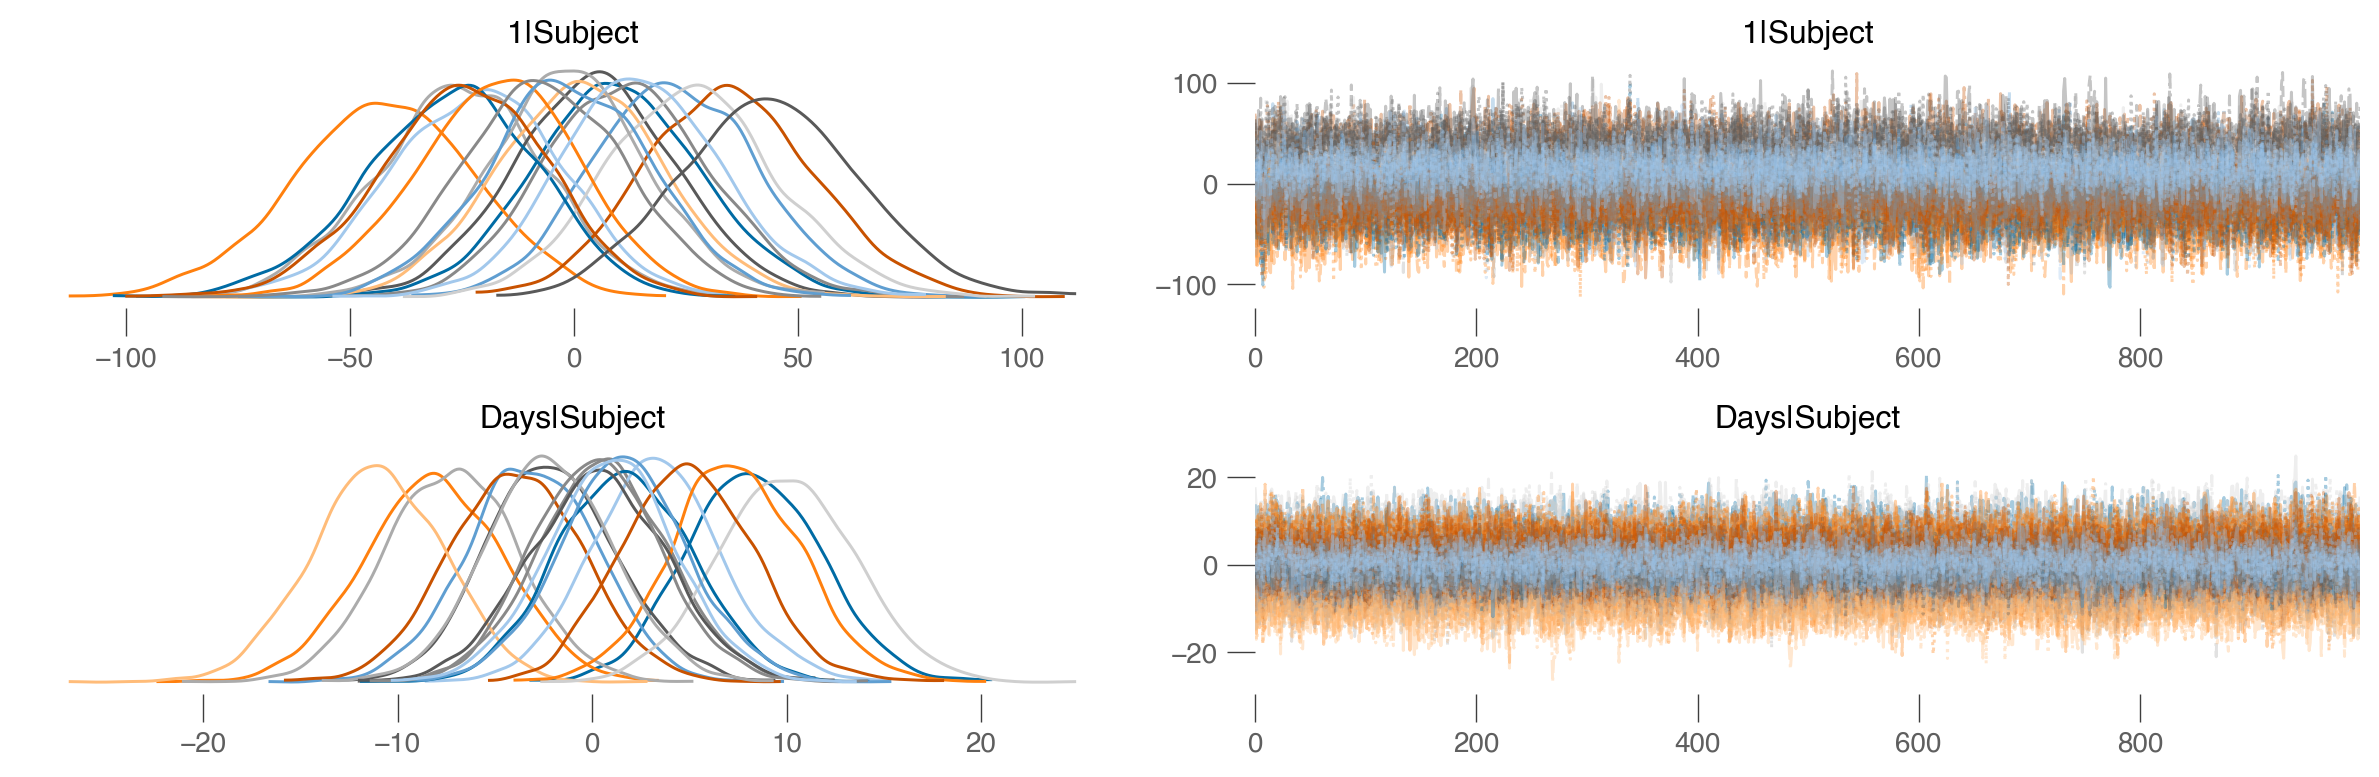

In [23]:
az.plot_trace(
    results_partial_pooling, combined=True, var_names=["1|Subject", "Days|Subject"]
)
plt.tight_layout()

Dall'ampiezza delle distribuzioni a posteriori delle intercette per i singoli soggetti possiamo vedere che il tempo di reazione medio iniziale per un determinato soggetto può differire notevolmente dalla media generale che abbiamo visto nella tabella precedente. C'è anche una grande differenza nelle pendenze. Alcuni soggetti vedono aumentare rapidamente i loro tempi di reazione quando vengono deprivati del sonno, mentre altri hanno una tolleranza migliore e peggiorano più lentamente. 

Una rappresentazione grafica della stima a posteriore dei parametri e dei dati si ottiene con `az.plot_forest()`.

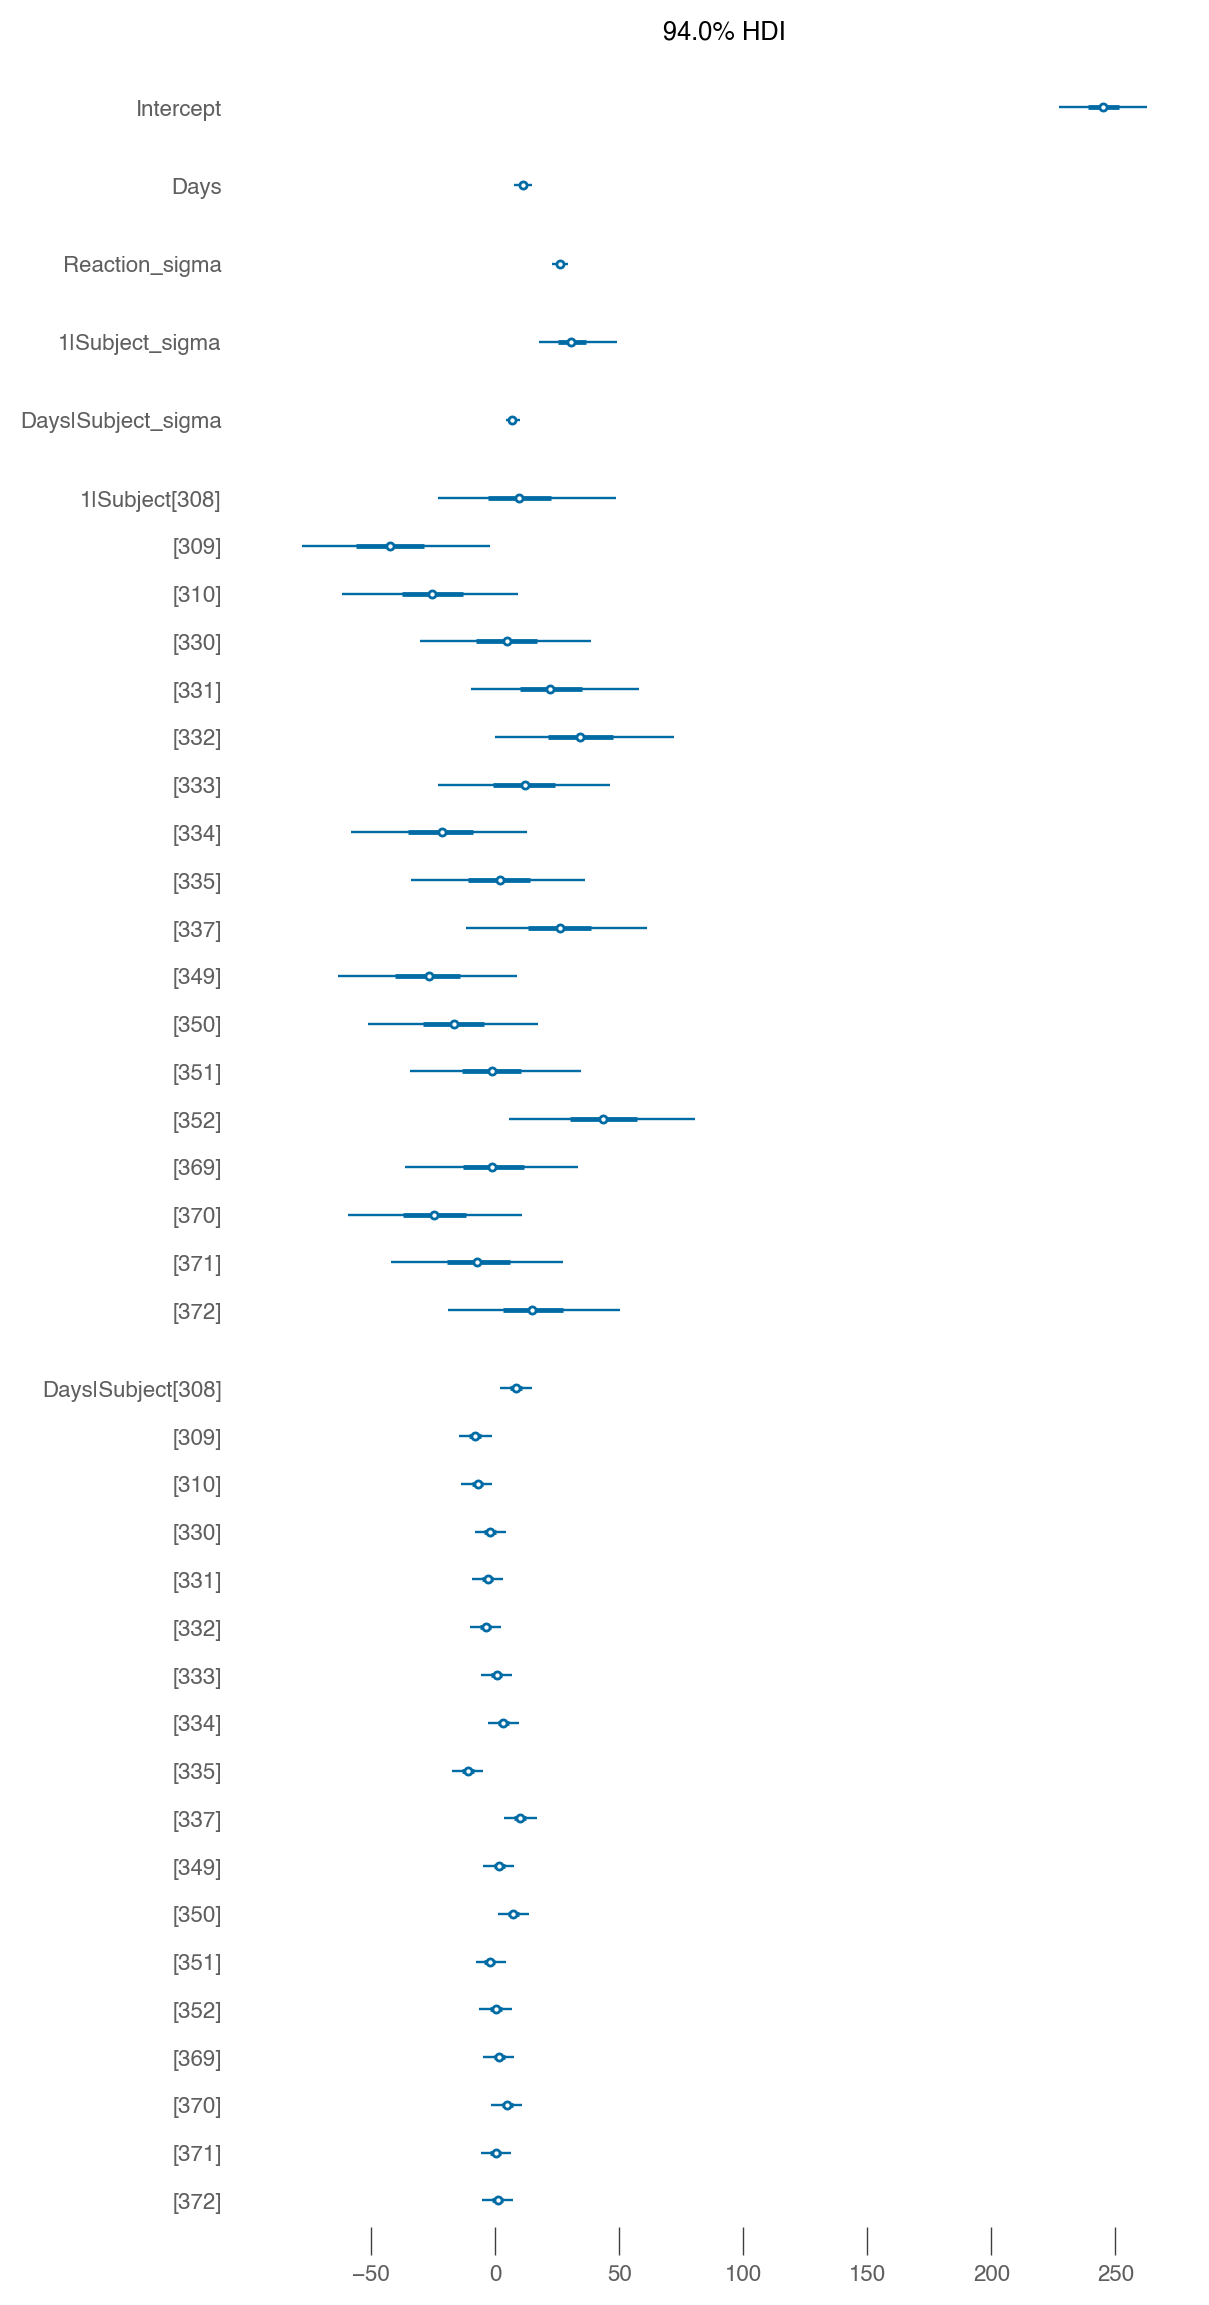

In [25]:
az.plot_forest(data=results_partial_pooling, r_hat=False, combined=True, textsize=8);

In sintesi, il modello gerarchico cattura il comportamento che abbiamo visto nella fase di esplorazione dei dati. Le persone differiscono sia nei tempi di reazione iniziali che nel modo in cui questi tempi di reazione sono influenzati dai giorni di deprivazione del sonno. Possiamo dunque giungere alle seguenti conclusioni:

- Il tempo di reazione medio delle persone aumenta quando sono deprivate del sonno.
- I soggetti hanno tempi di reazione diversi all'inizio dello studio.
- Alcuni soggetti sono più colpiti dalla privazione del sonno rispetto ad altri.
  
Ma c'è un'altra domanda a cui non abbiamo ancora risposto: I tempi di reazione iniziali sono associati a quanto la deprivazione del sonno influisce sull'evoluzione dei tempi di reazione? 

Creiamo un diagramma a dispersione per visualizzare le stime a posteriori congiunte delle intercette e delle pendenze specifiche per i soggetti. Questo grafico usa colori diversi per i soggetti. Se guardiamo il quadro generale, cioè trascurando i ragruppamenti dei dati in base ai soggetti, possiamo concludere che non c'è associazione tra l'intercetta e la pendenza. In altre parole, avere tempi di reazione iniziali più bassi o più alti non dice nulla su quanto la deprivazione del sonno influisca sul tempo di reazione medio di un determinato soggetto.

D'altra parte, se guardiamo la distribuzione a posteriori congiunta per un determinato individuo, possiamo vedere una correlazione negativa tra l'intercetta e la pendenza. Questo indica che, condizionalmente a un determinato soggetto, le stime a posteriori dell'intercetta e della pendenza non sono indipendenti. 

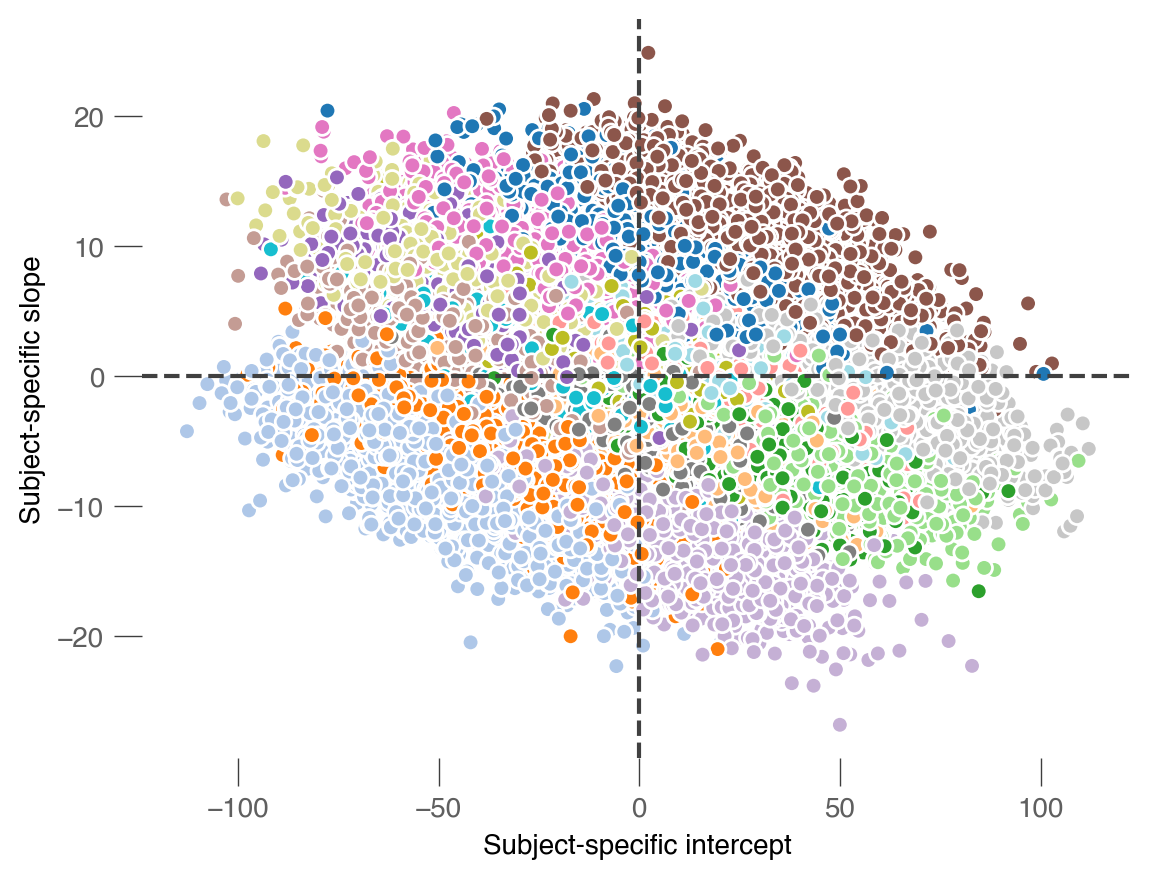

In [26]:
#  extract a subsample from the posterior and stack the chain and draw dims
posterior = az.extract(results_partial_pooling, num_samples=500)

_, ax = plt.subplots()

results_partial_pooling.posterior.plot.scatter(
    x="1|Subject", y="Days|Subject",
    hue="Subject__factor_dim",
    add_colorbar=False,
    add_legend=False,
    cmap="tab20",
    edgecolors=None,
)

ax.axhline(c="0.25", ls="--")
ax.axvline(c="0.25", ls="--")
ax.set_xlabel("Subject-specific intercept")
ax.set_ylabel("Subject-specific slope");

## Confronto dei modelli

Un aspetto finale e cruciale del nostro studio riguarda il confronto tra i diversi modelli che abbiamo esaminato. La nostra intenzione è determinare quale modello fornisce una rappresentazione migliore dei dati, trovando un equilibrio appropriato tra l'accuratezza del modello e la sua complessità, cioè la parsimonia.

Per raggiungere questo scopo, faremo uso della metrica ELPD (Expected Log Predictive Density), che abbiamo introdotto in precedenza. ELPD ci consente di valutare un modello in termini di adattamento ai dati, considerando sia l'accuratezza delle previsioni che la complessità del modello.

### Utilizzo di `az.compare()` 

In Python, possiamo sfruttare la funzione `az.compare()` per confrontare direttamente modelli bayesiani. Questa funzione accetta un dizionario contenente gli oggetti `InferenceData`, risultanti dalla funzione `Model.fit()`, e restituisce un dataframe. I modelli vengono ordinati dal migliore al peggiore in base ai criteri selezionati, e di default, ArviZ usa il criterio di convalida incrociata "leave one out" (LOO).

#### Convalida Incrociata "Leave One Out" (LOO)

LOO è una tecnica di convalida che addestra il modello su tutti i dati disponibili tranne uno, utilizzando il singolo punto escluso come dati di test. Questo processo viene ripetuto per ogni punto dati nel set, e la media delle misure di errore fornisce una stima accurata dell'errore di generalizzazione del modello. Anche se computazionalmente impegnativa, LOO fornisce una valutazione affidabile delle prestazioni del modello. In ArviZ, la funzione `loo` implementa questo metodo seguendo un approccio bayesiano.

#### Widely Applicable Information Criterion (WAIC)

Oltre a LOO, possiamo anche utilizzare il criterio WAIC (Widely Applicable Information Criterion). Il WAIC è uno strumento per la selezione del modello che mira a trovare il modello ottimale in un insieme di candidati, equilibrando l'adattamento ai dati e la complessità del modello, evitando così il sovradattamento. WAIC è particolarmente utile nel contesto bayesiano, poiché tiene conto dell'incertezza associata ai parametri del modello.

Sia LOO che WAIC possono essere visti come stime empiriche dell'ELPD, fornendo un quadro comprensivo delle prestazioni dei modelli.

### Conclusione

Utilizzando la funzione `az.compare()`, siamo in grado di effettuare una comparazione rapida ed efficace tra i diversi modelli, valutandoli secondo i criteri LOO e WAIC. Nel nostro caso specifico, il modello di "partial pooling" emerge come il migliore, presentando il valore ELPD stimato più alto. Questo risultato conferma la validità del modello nel rappresentare la struttura dei dati, tenendo conto delle differenze individuali all'interno dei cluster, e fornendo una stima coerente e informativa dell'effetto della deprivazione del sonno sul tempo di reazione.

In [27]:
models_dict = {
    "pooling": results_pooling,
    "no_pooling": results_no_pooling,
    "partial_pooling": results_partial_pooling
}
df_compare = az.compare(models_dict)
df_compare

/Users/corrado/mambaforge/envs/pymc_env/lib/python3.11/site-packages/arviz/stats/stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/Users/corrado/mambaforge/envs/pymc_env/lib/python3.11/site-packages/arviz/stats/stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/Users/corrado/mambaforge/envs

rank    elpd_loo      p_loo  elpd_diff    weight         se  \
partial_pooling     0 -693.352738  31.913543   0.000000  0.873105  22.079396   
no_pooling          1 -694.776642  35.969379   1.423904  0.077068  21.649608   
pooling             2 -772.271107   3.148901  78.918369  0.049827   9.029907   

                       dse  warning scale  
partial_pooling   0.000000     True   log  
no_pooling        3.349452     True   log  
pooling          20.644062    False   log

È importante sottolineare che, per ottenere una stima dell'ELPD (Expected Log Predictive Density), è necessario includere l'opzione `idata_kwargs={"log_likelihood": True}` all'interno della funzione responsabile dell'esecuzione del campionamento MCMC.

La figura che segue illustra visivamente le informazioni rilevanti per il confronto tra i diversi modelli. In grigio è indicata l'incertezza nella stima della differenza tra i valori ELPD dei diversi modelli.

/Users/corrado/mambaforge/envs/pymc_env/lib/python3.11/site-packages/arviz/plots/backends/matplotlib/compareplot.py:87: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  scale = comp_df["scale"][0]


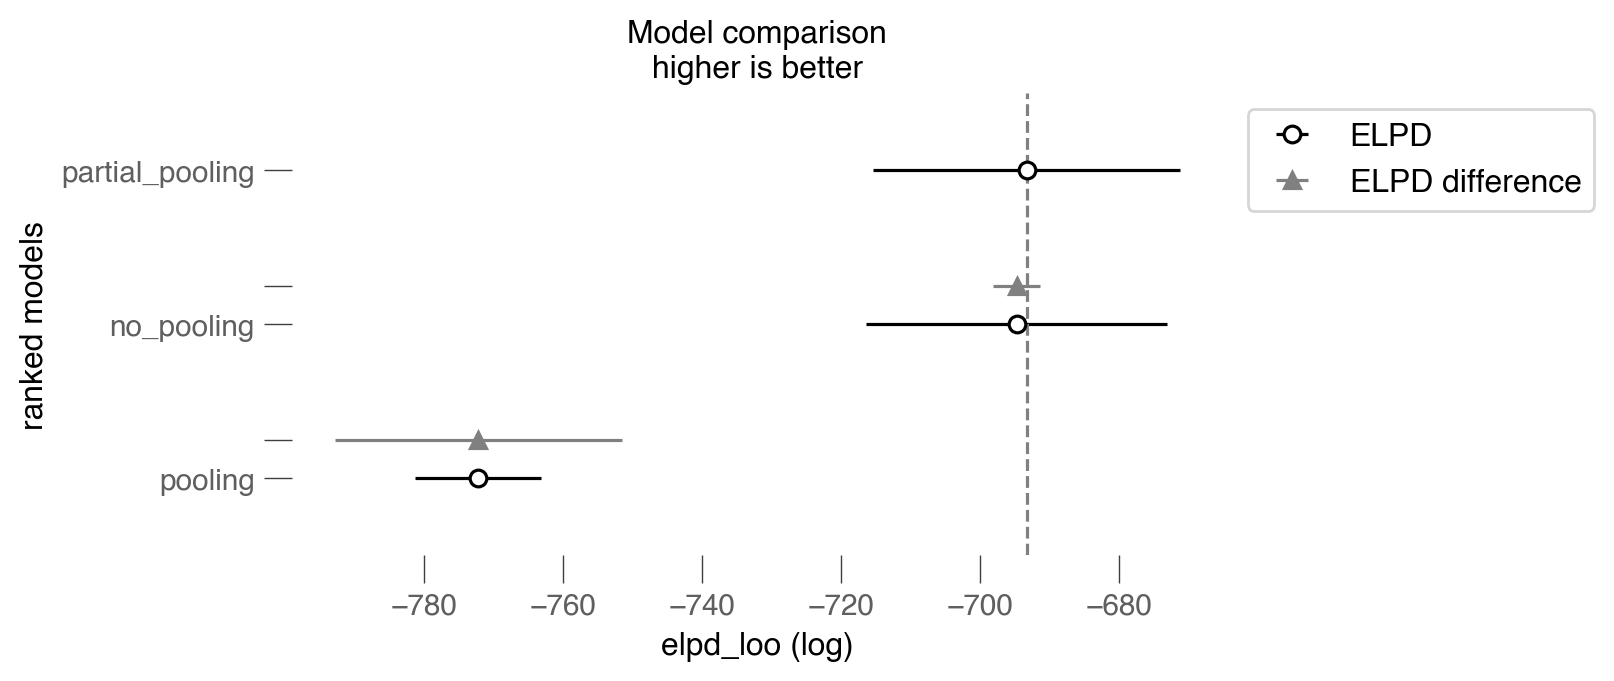

In [28]:
az.plot_compare(df_compare, insample_dev=False);

Il confronto tra i modelli guida il processo di selezione. In particolare, la comparazione tra il modello di partial-pooling e il modello completo di pooling è resa chiara dall'`elpd_diff` di 80.17 e dal suo errore standard di 19.97. Questi valori indicano inequivocabilmente che il modello di partial-pooling è superiore.

La situazione diventa più sfumata quando confrontiamo il modello di partial-pooling con il modello di no-pooling. In questo caso, le stime dell'ELPD mostrano una grande sovrapposizione, suggerendo che non c'è una differenza netta tra i due modelli in termini di adattamento ai dati.

Tuttavia, nonostante la vicinanza dei valori di ELPD, il modello di partial-pooling è da preferire. La ragione risiede nelle sue proprietà: esso fornisce stime più robuste e conservative delle differenze individuali. A differenza del modello di no-pooling, che può essere troppo sensibile alle variazioni all'interno dei cluster, il modello di partial-pooling incorpora un equilibrio tra la condivisione delle informazioni all'interno del gruppo e il riconoscimento delle differenze tra i gruppi. Questo lo rende più resistente alle fluttuazioni nei dati e offre una rappresentazione più affidabile delle relazioni sottostanti, rendendolo la scelta preferibile in questo contesto.

#### PPC plots

Per affrontare il tema della selezione di modelli, {cite:t}`Johnson2022bayesrules` usano anche il metodo dei *posterior predictive checks*.  Creiamo dunque i PPC plots per i tre modelli.

In [29]:
model_pooling_fitted = model_pooling.fit(
    method="nuts_numpyro", idata_kwargs={"log_likelihood": True}
)
model_pooling.predict(model_pooling_fitted, kind="pps")

/Users/corrado/mambaforge/envs/pymc_env/lib/python3.11/site-packages/bambi/models.py:307: FutureWarning: the method argument has been deprecated, please use inference_method
  warnings.warn(


Compiling...
Compilation time =  0:00:01.350153
Sampling...


Compiling.. :   0%|          | 0/2000 [00:00<?, ?it/s]






Running chain 0:   0%|          | 0/2000 [00:03<?, ?it/s]

Running chain 3: 100%|██████████| 2000/2000 [00:03<00:00, 600.41it/s]


Sampling time =  0:00:03.661175
Transforming variables...
Transformation time =  0:00:00.011005
Computing Log Likelihood...
Log Likelihood time =  0:00:00.122972


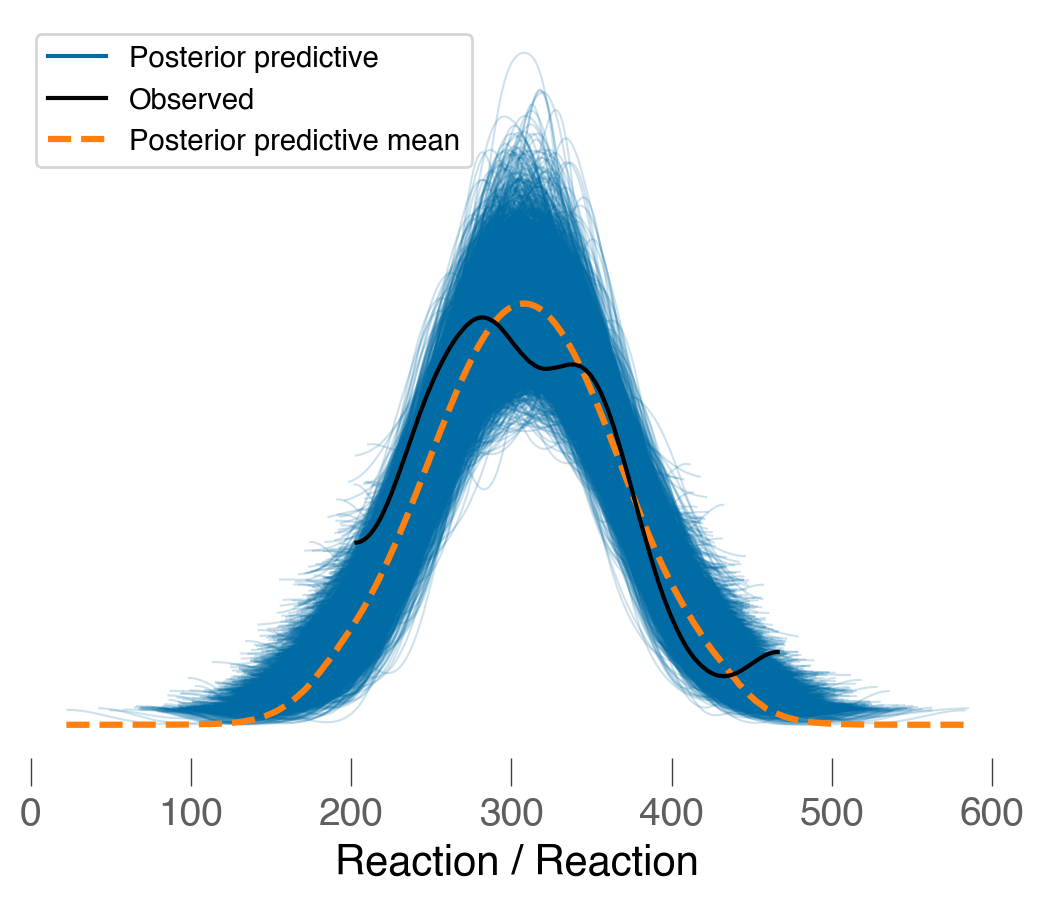

In [31]:
az.plot_ppc(model_pooling_fitted);

In [32]:
model_no_pooling_fitted = model_no_pooling.fit(
    method="nuts_numpyro", idata_kwargs={"log_likelihood": True}
)
model_no_pooling.predict(model_no_pooling_fitted, kind="pps");

/Users/corrado/mambaforge/envs/pymc_env/lib/python3.11/site-packages/bambi/models.py:307: FutureWarning: the method argument has been deprecated, please use inference_method
  warnings.warn(


Compiling...
Compilation time =  0:00:02.737982
Sampling...


Compiling.. :   0%|          | 0/2000 [00:00<?, ?it/s]





Running chain 0:   0%|          | 0/2000 [00:04<?, ?it/s]


Running chain 0:   5%|▌         | 100/2000 [00:04<00:06, 279.10it/s]


Running chain 0:  35%|███▌      | 700/2000 [00:04<00:00, 1878.09it/s]


Running chain 0:  70%|███████   | 1400/2000 [00:05<00:00, 3305.14it/s]


Running chain 3: 100%|██████████| 2000/2000 [00:05<00:00, 385.87it/s] 


Sampling time =  0:00:05.458689
Transforming variables...
Transformation time =  0:00:00.008776
Computing Log Likelihood...
Log Likelihood time =  0:00:00.186378


<Axes: xlabel='Reaction / Reaction'>

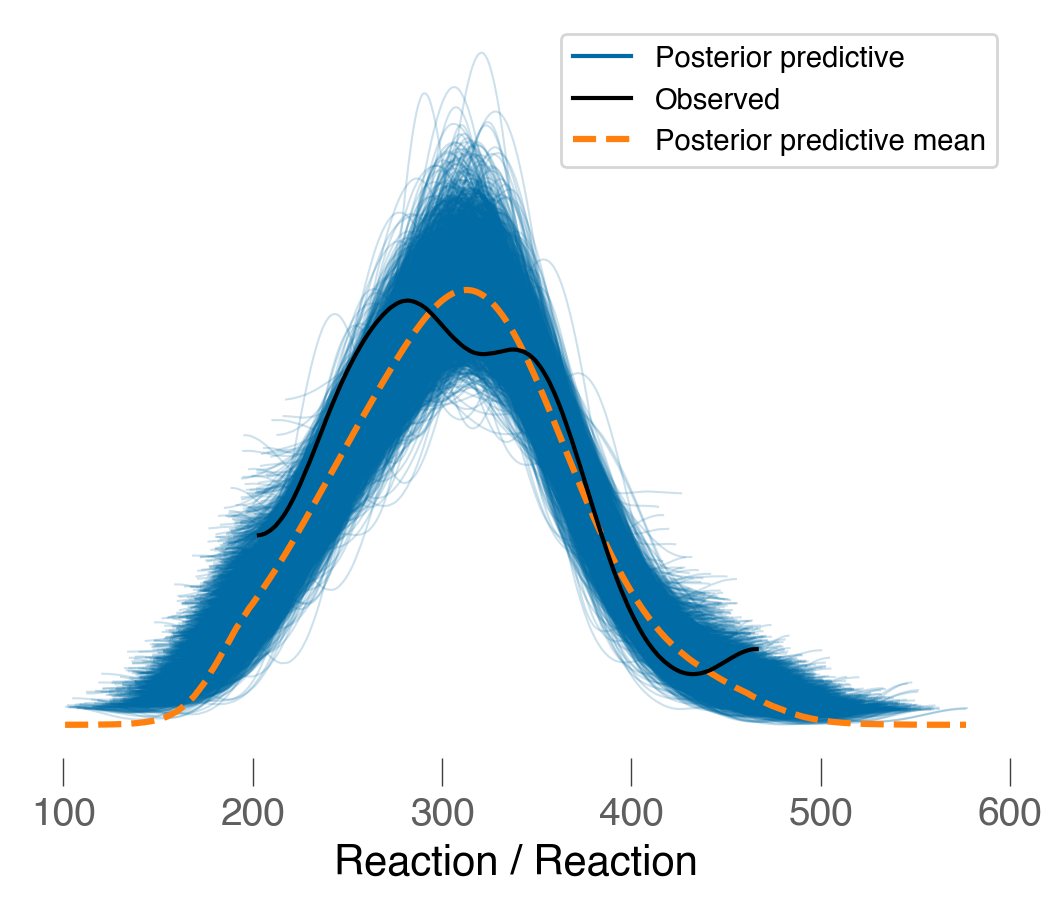

In [26]:
az.plot_ppc(model_no_pooling_fitted);

In [27]:
model_partial_pooling_fitted = model_partial_pooling.fit(
    method="nuts_numpyro", idata_kwargs={"log_likelihood": True}
)
model_partial_pooling.predict(model_partial_pooling_fitted, kind="pps");

/Users/corrado/mambaforge/envs/pymc_env/lib/python3.11/site-packages/bambi/models.py:307: FutureWarning: the method argument has been deprecated, please use inference_method
  warnings.warn(


Compiling...
Compilation time =  0:00:03.474775
Sampling...


Compiling.. :   0%|          | 0/2000 [00:00<?, ?it/s]






Running chain 0:   0%|          | 0/2000 [00:06<?, ?it/s]




Running chain 0:  15%|█▌        | 300/2000 [00:06<00:00, 2451.60it/s]


Running chain 0:  35%|███▌      | 700/2000 [00:06<00:00, 3152.58it/s]


Running chain 0:  55%|█████▌    | 1100/2000 [00:06<00:00, 3488.75it/s]


Running chain 0:  75%|███████▌  | 1500/2000 [00:06<00:00, 3444.41it/s]

Running chain 3: 100%|██████████| 2000/2000 [00:06<00:00, 296.80it/s] 


Sampling time =  0:00:07.106049
Transforming variables...
Transformation time =  0:00:00.036911
Computing Log Likelihood...
Log Likelihood time =  0:00:00.335159


<Axes: xlabel='Reaction / Reaction'>

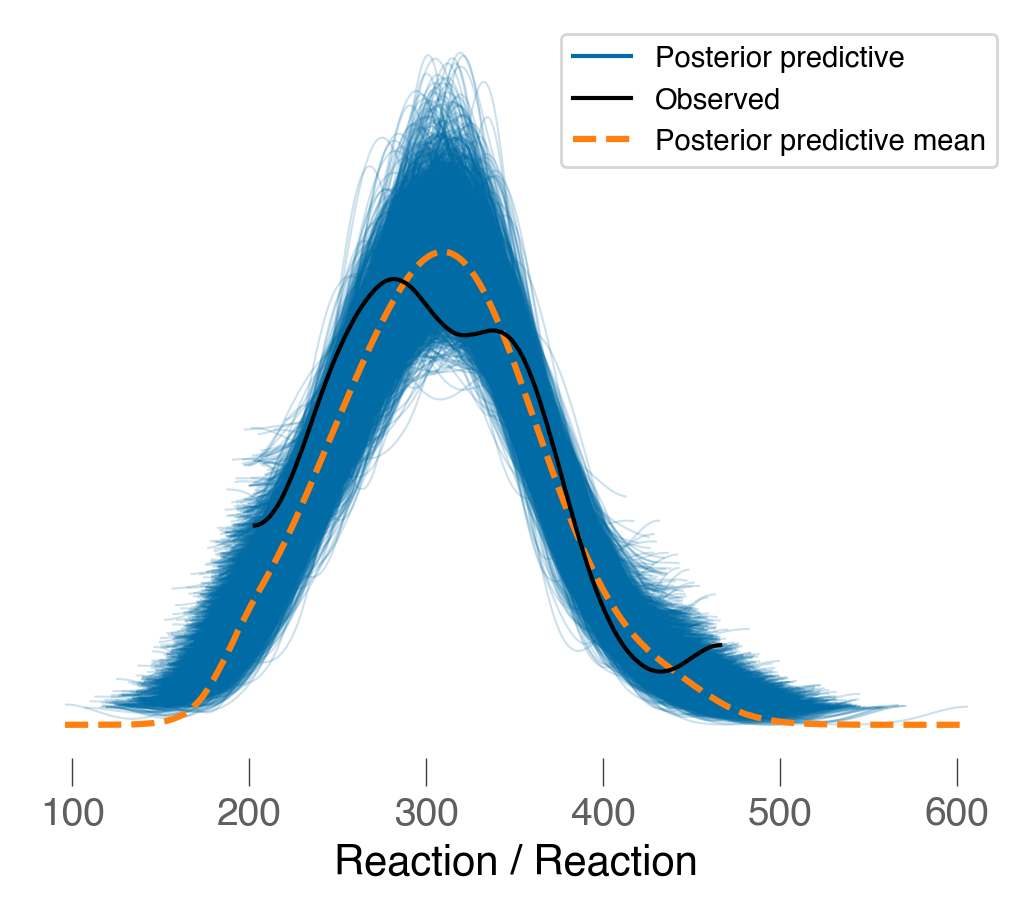

In [28]:
az.plot_ppc(model_partial_pooling_fitted);

In questo contesto specifico, l'analisi tramite i PPC (Posterior Predictive Checks) plots non rivela differenze evidenti tra i tre modelli in esame: tutti sembrano egualmente adeguati nell'adattarsi ai dati. Di conseguenza, i PPC plots non forniscono ulteriori chiarimenti o conferme alle conclusioni già raggiunte attraverso il confronto tra modelli basato sulla differenza ELPD (Expected Log Predictive Density). In altre parole, l'analisi visiva tramite i PPC plots non aggiunge valore o informazioni supplementari a quanto già dedotto dalle metriche di confronto.

## Commenti conclusivi

In questo capitolo, abbiamo confrontato i modelli di pooling, no pooling, e partial pooling utilizzando i dati del "sleepstudy." Ogni modello ha presentato aspetti distintivi: il pooling per la sua struttura comune, il no pooling per la sua indipendenza tra i gruppi, e il partial pooling come un compromesso equilibrato.

L'analisi basata sulla differenza Expected Log Predictive Density (ELPD) è stata cruciale nella selezione del modello più appropriato. Benché ciascun modello abbia avuto i propri vantaggi, la valutazione tramite ELPD ha fornito una misura oggettiva della qualità di adattamento, guidando la scelta verso il modello che meglio rappresenta la struttura sottostante dei dati.

In conclusione, l'approccio combinato di comprendere le caratteristiche dei modelli e applicare metodi quantitativi come l'ELPD ha permesso una selezione di modelli informata ed efficace.

## Watermark

In [29]:
%load_ext watermark
%watermark -n -u -v -iv -w -p pytensor

Last updated: Fri Sep 01 2023

Python implementation: CPython
Python version       : 3.11.5
IPython version      : 8.14.0

pytensor: 2.14.2

arviz     : 0.16.1
numpy     : 1.25.2
xarray    : 2023.8.0
pingouin  : 0.5.3
matplotlib: 3.7.2
pandas    : 2.1.0
pymc      : 5.7.2
seaborn   : 0.12.2
bambi     : 0.12.0

Watermark: 2.4.3

